# NLP

*Gina Martínez López*

Considere la siguiente base

"https://raw.githubusercontent.com/Fabian830348/Bases_Datos/master/tweets.csv"

Estos tweets estan clasificados como: *positivos*, *neutros* o *negativos*

**Objetivos**

- Aplicar las técnicas de limpieza para normalizar un texto

- Reconocer los elementos de la creación de una bolsa de palabras por **TF** y por **TF-iDF**.

- Aplicar Naive-Bayes para clasificar textos y comparar los resultados de NB con otros algoritmos.


## Punto 1

**a) Gráfico de barras de la clasificación de comentarios. ¿Cuántos positivos, negativo y neutros?**

In [ ]:
pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 KB 4.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import re
import nltk
from nltk.corpus import stopwords
import itertools
from unidecode import unidecode
import csv
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

warnings.filterwarnings('ignore')
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
url = "https://raw.githubusercontent.com/Fabian830348/Bases_Datos/master/tweets.csv"

df= pd.read_csv(url)
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [ ]:
# Renombramiento de las columnas 
df.columns = ['Tweet_text', 'Directed_at','Emotion'] 
df.head()

,Tweet_text,Directed_at,Emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


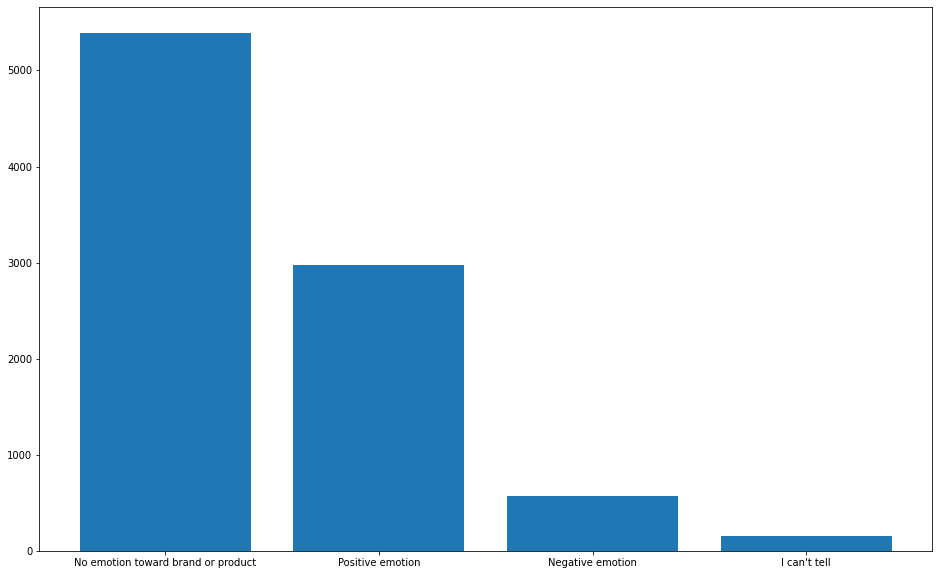

In [ ]:
count_emotions = df.Emotion.value_counts()

plt.figure(figsize=(16,10))
plt.bar(count_emotions.index,count_emotions)
plt.show()

In [ ]:
print("Numero de comentarios neutros: ", count_emotions[0]+count_emotions[3])
print("\nNumero de comentarios positivos: ", count_emotions[1])
print("\nNumero de comentarios negativos: ", count_emotions[2])

Numero de comentarios neutros:  5545

Numero de comentarios positivos:  2978

Numero de comentarios negativos:  570


**b) Gráfico de barras acerca del producto evaluado.**

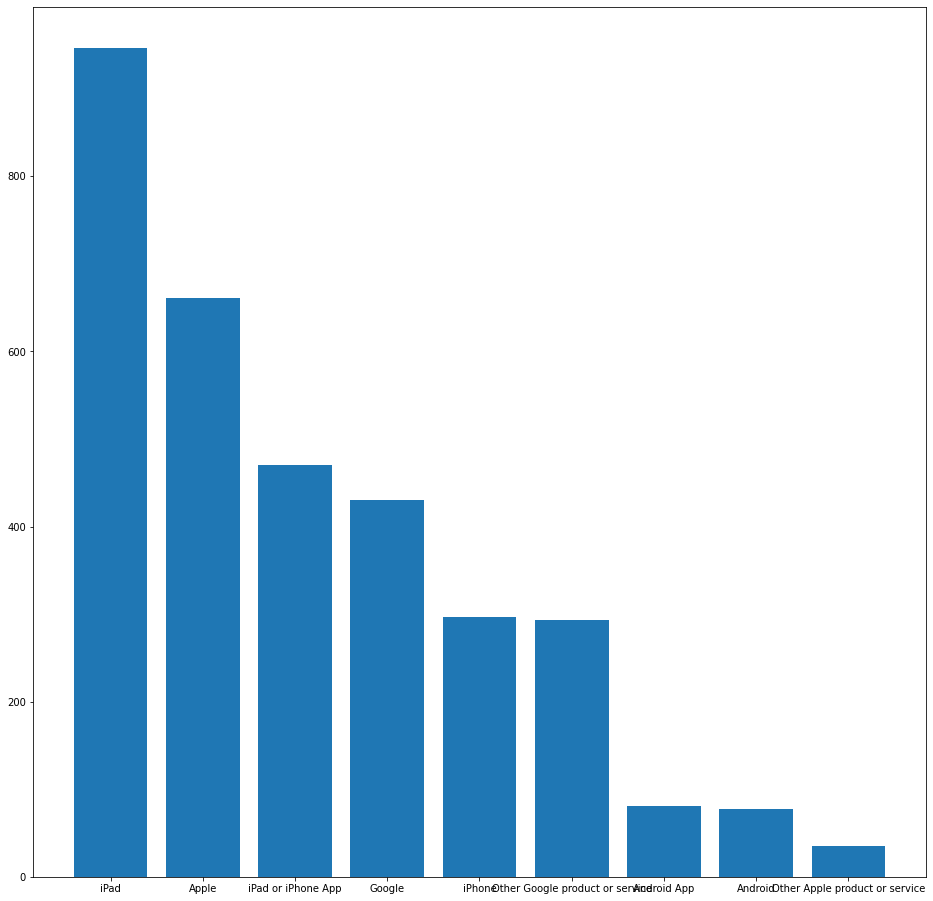

In [ ]:
count_product = df.Directed_at.value_counts()
plt.figure(figsize=(16,16))
plt.bar(count_product.index,count_product)
plt.show()

In [ ]:
print("Numero de comentarios a ",count_product.index[0],'es de ', count_product[0])
print("Numero de comentarios a ",count_product.index[1],'es de ', count_product[1])
print("Numero de comentarios a ",count_product.index[2],'es de ', count_product[2])
print("Numero de comentarios a ",count_product.index[3],'es de ', count_product[3])
print("Numero de comentarios a ",count_product.index[4],'es de ', count_product[4])
print("Numero de comentarios a ",count_product.index[5],'es de ', count_product[5])
print("Numero de comentarios a ",count_product.index[6],'es de ', count_product[6])
print("Numero de comentarios a ",count_product.index[7],'es de ', count_product[7])
print("Numero de comentarios a ",count_product.index[8],'es de ', count_product[8])

Numero de comentarios a  iPad es de  946
Numero de comentarios a  Apple es de  661
Numero de comentarios a  iPad or iPhone App es de  470
Numero de comentarios a  Google es de  430
Numero de comentarios a  iPhone es de  297
Numero de comentarios a  Other Google product or service es de  293
Numero de comentarios a  Android App es de  81
Numero de comentarios a  Android es de  78
Numero de comentarios a  Other Apple product or service es de  35


**c) ¿Cuál categoría de producto tiene más comentarios positivos? ¿negativos?**

In [ ]:
df1 = df.loc[df.loc[:, 'Emotion'] == 'Positive emotion']
pos_com = df1.Directed_at.value_counts()
print("Producto con mayores comentarios positivos: ", pos_com.index[0], "con ", pos_com[0])

df2 = df.loc[df.loc[:, 'Emotion'] == 'Negative emotion']
neg_com = df2.Directed_at.value_counts()
print("Producto con mayores comentarios negativos: ", neg_com.index[0], "con ", neg_com[0])

Producto con mayores comentarios positivos:  iPad con  793
Producto con mayores comentarios negativos:  iPad con  125


# Punto 2

Normalización (en ingles) de los tweets. Preprocesamiento de los datos; pasar a minúscula, eliminar algunos signos, quitar los @ y #, stop words, etc.

In [ ]:
df_clean = df[df["Tweet_text"].isna() == False] # quitamos valores NA

In [ ]:
# funcion para quitar tildes del texto en minuscula
def remove_tildes(s):
    return unidecode(s)

stopwords_english = set(stopwords.words('english'))
stopwords_english.add('')

# funcion que hace todo el preprocesamiento esta vez en ingles
# devuelve una lista de palabras, para cada tweet
def pre_procesamiento(texto):
    new_text = texto.lower()  # pasamos a minusculas
    new_text = remove_tildes(new_text)                      # removemos tildes
    new_text = re.compile(r'\W+', re.UNICODE).split(new_text)  # removemos caracteres especiales
    new_text = [x for x in new_text if x not in stopwords_english]
    return new_text

tweets_clean = []
for tweet in df_clean["Tweet_text"]:
    tweets_clean.extend(pre_procesamiento(tweet))

# 3. Construir bolsa de palabras con TF y con TF-iDF

In [ ]:
len(tweets_clean)

114272

In [ ]:
# usamos la funcion de Scikit para la hacer la bolsa de palabras TF
cv = CountVectorizer()
cv_fit = cv.fit_transform(tweets_clean)
# Resultados
print(cv.get_feature_names_out())
print(cv_fit.toarray())

['00' '000' '00am' ... 'zuckerberg' 'zynga' 'zzzs']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
# usamos la funcion de Scikit para la hacer la bolsa de palabras TF-IDF
tfidf = TfidfVectorizer()
corpus = tfidf.fit_transform(tweets_clean)

# Resultados
print(tfidf.get_feature_names_out ())
print(corpus.toarray())

['00' '000' '00am' ... 'zuckerberg' 'zynga' 'zzzs']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# 4. Aplicar los modelos para TF y TF-iDF. Para este último tener el cuenta las 1000 palabras más frecuentes y las palabras que aparezcan mínimo en 3 documentos.

Queremos ver el top 1000 de las palabras mas frecuentes de los tweets

In [ ]:
frecuencias={}
for palabra in tweets_clean:
    if palabra in frecuencias:
        frecuencias[palabra]+=1
    else:
        frecuencias[palabra]=1
print(frecuencias) 

{'wesley83': 1, '3g': 30, 'iphone': 1588, '3': 183, 'hrs': 4, 'tweeting': 28, 'rise_austin': 2, 'dead': 18, 'need': 205, 'upgrade': 13, 'plugin': 4, 'stations': 2, 'sxsw': 9632, 'jessedee': 1, 'know': 186, 'fludapp': 1, 'awesome': 136, 'ipad': 2518, 'app': 826, 'likely': 13, 'appreciate': 5, 'design': 143, 'also': 79, 'giving': 71, 'free': 390, 'ts': 2, 'swonderlin': 1, 'wait': 77, '2': 1187, 'sale': 30, 'hope': 52, 'year': 126, 'festival': 32, 'crashy': 2, 'sxtxstate': 9, 'great': 222, 'stuff': 36, 'fri': 7, 'marissa': 193, 'mayer': 218, 'google': 2667, 'tim': 19, 'reilly': 9, 'tech': 150, 'books': 7, 'conferences': 40, 'amp': 836, 'matt': 12, 'mullenweg': 3, 'wordpress': 9, 'teachntech00': 1, 'new': 1091, 'apps': 225, 'speechtherapy': 3, 'communication': 20, 'showcased': 20, 'conference': 33, 'http': 22, 'ht': 11, 'ly': 36, '49n4m': 1, 'iear': 3, 'edchat': 39, 'asd': 3, 'starting': 34, 'ctia': 4, 'around': 132, 'corner': 13, 'googleio': 2, 'hop': 3, 'skip': 3, 'jump': 6, 'good': 173,

In [ ]:
sorted_x = sorted(frecuencias.items(), key=lambda y: y[1],reverse=True)
#sorted_x[:10]

In [ ]:
sorted_x = sorted(frecuencias.keys(), key=lambda y: frecuencias[y],reverse=True)
top=sorted_x[:1000] #top de las 1000 palabras

Bolsa de palabras con el top de las 1000 palabras, solo para poder observarlas.

In [ ]:
# Dividir los datos en conjunto de entrenamiento y de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_clean['Tweet_text'], df_clean['Emotion'], random_state=1)
print('Number of rows in the total set: {}'.format(df_clean.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 9092
Number of rows in the training set: 6819
Number of rows in the test set: 2273


In [ ]:
X_test

255     Backupify Announces CloudSight Search, the Fir...
3925    Q&amp;A With Google &amp; Bing On Website Rank...
1523    @mention “@mention Does the pop up Apple store...
8025    Someone asks Leo about an iPad 2 at #SXSW, he ...
6513    RT @mention RT @mention Arriving in the US for...
                              ...                        
7836    Apple does a popup store just for #sxsw {link}...
8259    my biggest mistake since South By Southwest la...
2572    That sounds...fantastic. RT @mention At the Go...
5869    RT @mention Google to Launch Major New Social ...
5645    RT @mention Cool. Apple sets up 5,000 sq. ft. ...
Name: Tweet_text, Length: 2273, dtype: object

In [ ]:
# Bolsa de palabras TF que obtiene las primeras 1000 que aparezcan en 3 tweets
cv = CountVectorizer(min_df=3, max_features=1000)

datos_train = cv.fit_transform(X_train)

datos_test = cv.transform(X_test)

# Bolsa de palabras TF-iDF que obtiene las primeras 1000 que aparezcan en 3 tweets
tfidf = TfidfVectorizer(min_df=3, max_features=1000)

datos_train_idf = tfidf.fit_transform(X_train)

datos_test_idf = tfidf.transform(X_test)


## Naive Bayes Bernoulli

**Datos TF**

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bernoulli = BernoulliNB()
bernoulli.fit(datos_train, y_train)

# hacemos la prediccion de los datos de entrenamiento  
train_pred = bernoulli.predict(datos_train)

# hacemos la orediccion de los datos de prueba 
test_pred = bernoulli.predict(datos_test)

Una vez se obtinen las predicciones del modelo para la clasificacion de los datos tanto de prueba como de entrenamiento, se procede a evaluar la clasificacion del modelo.

In [ ]:
# Metricas para los datos de test
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print('Accuracy score: ', format(accuracy_score(y_test, test_pred)))
print('Precision score: ', format(precision_score(y_test, test_pred,average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred,average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred,average='macro')))
BTF_ACC_TEST =  accuracy_score(y_test, test_pred)
BTF_PS_TEST = precision_score(y_test, test_pred,average='macro')
BTF_RS_TEST = recall_score(y_test, test_pred,average='macro')
BTF_F1_TEST = f1_score(y_test, test_pred,average='macro')

Accuracy score:  0.6102067751869775
Precision score:  0.3678047588005215
Recall score:  0.39129799827782097
F1 score:  0.3767004731244388


In [ ]:
# Metricas para los datos de train
print('Accuracy score: ', format(accuracy_score(y_train, train_pred)))
print('Precision score: ', format(precision_score(y_train, train_pred,average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred,average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred,average='macro')))
BTF_ACC_TRAIN =  accuracy_score(y_train, train_pred)
BTF_PS_TRAIN = precision_score(y_train, train_pred,average='macro')
BTF_RS_TRAIN = recall_score(y_train, train_pred,average='macro')
BTF_F1_TRAIN = f1_score(y_train, train_pred,average='macro')

Accuracy score:  0.6760522070684851
Precision score:  0.5711130616097693
Recall score:  0.4990229869201187
F1 score:  0.4897028086225538


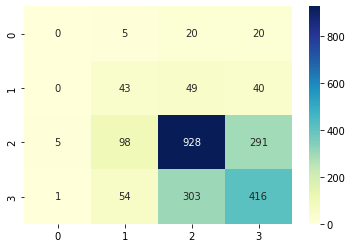

In [ ]:
# generamos la matriz de confusion
MC2 = metrics.confusion_matrix(y_test, test_pred)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

In [ ]:
print(classification_report(y_test,test_pred))

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        45
                  Negative emotion       0.21      0.33      0.26       132
No emotion toward brand or product       0.71      0.70      0.71      1322
                  Positive emotion       0.54      0.54      0.54       774

                          accuracy                           0.61      2273
                         macro avg       0.37      0.39      0.38      2273
                      weighted avg       0.61      0.61      0.61      2273



**Datos TF-iDF**

In [ ]:
bernoulli_2 = BernoulliNB()
bernoulli_2.fit(datos_train_idf, y_train)

# hacemos la prediccion de los datos iDF de entrenamiento  
train_pred_idf = bernoulli_2.predict(datos_train_idf)

# hacemos la orediccion de los datos iDF de prueba 
test_pred_idf = bernoulli_2.predict(datos_test_idf)

Procedemos a hacer la evaluacion del modelo con los datos de TF-iDF

In [ ]:
# Metricas para los datos de prueba de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_test, test_pred_idf)))
print('Precision score: ', format(precision_score(y_test, test_pred_idf, average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred_idf, average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred_idf, average='macro')))

BTFI_ACC_TEST =  accuracy_score(y_test, test_pred_idf)
BTFI_PS_TEST = precision_score(y_test, test_pred_idf, average='macro')
BTFI_RS_TEST = recall_score(y_test, test_pred_idf, average='macro')
BTFI_F1_TEST = f1_score(y_test, test_pred_idf, average='macro')

Accuracy score:  0.6102067751869775
Precision score:  0.3678047588005215
Recall score:  0.39129799827782097
F1 score:  0.3767004731244388


In [ ]:
# Metricas para los datos de entrenamiento de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_train, train_pred_idf)))
print('Precision score: ', format(precision_score(y_train, train_pred_idf,average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred_idf,average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred_idf,average='macro')))

BTFI_ACC_TRAIN =  accuracy_score(y_train, train_pred_idf)
BTFI_PS_TRAIN = precision_score(y_train, train_pred_idf, average='macro')
BTFI_RS_TRAIN = recall_score(y_train, train_pred_idf, average='macro')
BTFI_F1_TRAIN = f1_score(y_train, train_pred_idf, average='macro')

Accuracy score:  0.6760522070684851
Precision score:  0.5711130616097693
Recall score:  0.4990229869201187
F1 score:  0.4897028086225538


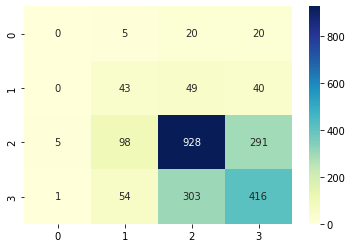

In [ ]:
# generamos la matriz de confusion para TF-iDF
MC2 = metrics.confusion_matrix(y_test, test_pred_idf)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

In [ ]:
print(classification_report(y_test,test_pred_idf))

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        45
                  Negative emotion       0.21      0.33      0.26       132
No emotion toward brand or product       0.71      0.70      0.71      1322
                  Positive emotion       0.54      0.54      0.54       774

                          accuracy                           0.61      2273
                         macro avg       0.37      0.39      0.38      2273
                      weighted avg       0.61      0.61      0.61      2273



### Naive Bayes Multinomial

**Datos TF**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(datos_train, y_train)


MultinomialNB()

In [ ]:
# hacemos la prediccion de los datos de entrenamiento  
train_pred = naive_bayes.predict(datos_train)

# hacemos la orediccion de los datos de prueba 
test_pred = naive_bayes.predict(datos_test)

In [ ]:
# Metricas para los datos de test
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
print('Accuracy score: ', format(accuracy_score(y_test, test_pred)))
print('Precision score: ', format(precision_score(y_test, test_pred,average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred,average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred,average='macro')))
NBMTF_ACC_TEST =  accuracy_score(y_test, test_pred)
NBMTF_PS_TEST = precision_score(y_test, test_pred,average='macro')
NBMTF_RS_TEST = recall_score(y_test, test_pred,average='macro')
NBMTF_F1_TEST = f1_score(y_test, test_pred,average='macro')

Accuracy score:  0.6106467223933129
Precision score:  0.36929374042688623
Recall score:  0.39489676965268916
F1 score:  0.37858441641853224


In [ ]:
# Metricas para los datos de train
print('Accuracy score: ', format(accuracy_score(y_train, train_pred)))
print('Precision score: ', format(precision_score(y_train, train_pred,average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred,average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred,average='macro')))
NBMTF_ACC_TRAIN =  accuracy_score(y_train, train_pred)
NBMTF_PS_TRAIN = precision_score(y_train, train_pred,average='macro')
NBMTF_RS_TRAIN = recall_score(y_train, train_pred,average='macro')
NBMTF_F1_TRAIN = f1_score(y_train, train_pred,average='macro')

Accuracy score:  0.6773720486874908
Precision score:  0.5572815440693684
Recall score:  0.5222179395253294
F1 score:  0.5146031564324146


**Matriz de Confusión** 

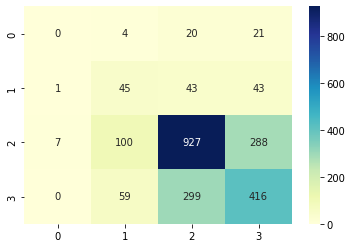

In [ ]:
# generamos la matriz de confusion
MC2 = metrics.confusion_matrix(y_test, test_pred)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

In [ ]:
print(classification_report(y_test,test_pred))

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        45
                  Negative emotion       0.22      0.34      0.26       132
No emotion toward brand or product       0.72      0.70      0.71      1322
                  Positive emotion       0.54      0.54      0.54       774

                          accuracy                           0.61      2273
                         macro avg       0.37      0.39      0.38      2273
                      weighted avg       0.62      0.61      0.61      2273



**Datos TF-iDF**

In [ ]:
naive_bayes_2 = MultinomialNB()
naive_bayes_2.fit(datos_train_idf, y_train)

# hacemos la prediccion de los datos iDF de entrenamiento  
train_pred_idf = naive_bayes_2.predict(datos_train_idf)

# hacemos la orediccion de los datos iDF de prueba 
test_pred_idf = naive_bayes_2.predict(datos_test_idf)

In [ ]:
# Metricas para los datos de prueba de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_test, test_pred_idf)))
print('Precision score: ', format(precision_score(y_test, test_pred_idf, average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred_idf, average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred_idf, average='macro')))

NBMTFI_ACC_TEST =  accuracy_score(y_test, test_pred_idf)
NBMTFI_PS_TEST = precision_score(y_test, test_pred_idf, average='macro')
NBMTFI_RS_TEST = recall_score(y_test, test_pred_idf, average='macro')
NBMTFI_F1_TEST = f1_score(y_test, test_pred_idf, average='macro')

Accuracy score:  0.6418829740431148
Precision score:  0.44303427301438764
Recall score:  0.3141287803269297
F1 score:  0.305133101673724


In [ ]:
# Metricas para los datos de entrenamiento de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_train, train_pred_idf)))
print('Precision score: ', format(precision_score(y_train, train_pred_idf,average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred_idf,average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred_idf,average='macro')))

NBMTFI_ACC_TRAIN =  accuracy_score(y_train, train_pred_idf)
NBMTFI_PS_TRAIN = precision_score(y_train, train_pred_idf, average='macro')
NBMTFI_RS_TRAIN = recall_score(y_train, train_pred_idf, average='macro')
NBMTFI_F1_TRAIN = f1_score(y_train, train_pred_idf, average='macro')

Accuracy score:  0.696583076697463
Precision score:  0.553791447630914
Recall score:  0.3529105561649567
F1 score:  0.3589048613698047


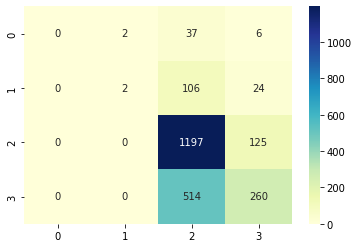

In [ ]:
# generamos la matriz de confusion para TF-iDF
MC2 = metrics.confusion_matrix(y_test, test_pred_idf)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

In [ ]:
print(classification_report(y_test,test_pred_idf))

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        45
                  Negative emotion       0.50      0.02      0.03       132
No emotion toward brand or product       0.65      0.91      0.75      1322
                  Positive emotion       0.63      0.34      0.44       774

                          accuracy                           0.64      2273
                         macro avg       0.44      0.31      0.31      2273
                      weighted avg       0.62      0.64      0.59      2273



## Regresion Logistica

**Datos TF**

In [ ]:
from sklearn.linear_model import LogisticRegression

logistica = LogisticRegression()
logistica.fit(datos_train, y_train)

# hacemos la prediccion de los datos de entrenamiento  
train_pred = logistica.predict(datos_train)

# hacemos la orediccion de los datos de prueba 
test_pred = logistica.predict(datos_test)

Procedemos a evaluar el modelo




In [ ]:
# Metricas para evaluar el modelo con los datos de prueba 
print('Accuracy score: ', format(accuracy_score(y_test, test_pred)))
print('Precision score: ', format(precision_score(y_test, test_pred,average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred,average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred,average='macro')))

LTF_ACC_TEST = accuracy_score(y_test, test_pred)
LTF_PS_TEST = precision_score(y_test, test_pred,average='macro')
LTF_RS_TEST = recall_score(y_test, test_pred,average='macro')
LTF_F1_TEST = f1_score(y_test, test_pred,average='macro')

Accuracy score:  0.6462824461064672
Precision score:  0.4699435983860019
Recall score:  0.3733527265051031
F1 score:  0.3829359163884115


In [ ]:
# Metricas para evaluar el modelo con los datos de prueba 
print('Accuracy score: ', format(accuracy_score(y_train, train_pred)))
print('Precision score: ', format(precision_score(y_train, train_pred, average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred, average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred, average='macro')))

LTF_ACC_TRAIN = accuracy_score(y_train, train_pred)
LTF_PS_TRAIN = precision_score(y_train, train_pred,average='macro')
LTF_RS_TRAIN = recall_score(y_train, train_pred,average='macro')
LTF_F1_TRAIN = f1_score(y_train, train_pred,average='macro')

Accuracy score:  0.7614019650975217
Precision score:  0.8052847699234591
Recall score:  0.5211979089481755
F1 score:  0.568687160268506


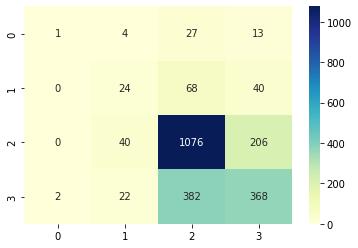

In [ ]:
# generamos la matriz de confusion
MC2 = metrics.confusion_matrix(y_test, test_pred)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

In [ ]:
print(classification_report(y_test,test_pred))

                                    precision    recall  f1-score   support

                      I can't tell       0.33      0.02      0.04        45
                  Negative emotion       0.27      0.18      0.22       132
No emotion toward brand or product       0.69      0.81      0.75      1322
                  Positive emotion       0.59      0.48      0.53       774

                          accuracy                           0.65      2273
                         macro avg       0.47      0.37      0.38      2273
                      weighted avg       0.62      0.65      0.63      2273



**Datos TF-iDF**

In [ ]:
logistica_2 = LogisticRegression()
logistica_2.fit(datos_train_idf, y_train)

# hacemos la prediccion de los datos iDF de entrenamiento  
train_pred_idf = logistica_2.predict(datos_train_idf)

# hacemos la orediccion de los datos iDF de prueba 
test_pred_idf = logistica_2.predict(datos_test_idf)

Evaluamos el modelo para TF-iDF

In [ ]:
# Metricas para evaluar el modelo con los datos de prueba de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_test, test_pred_idf)))
print('Precision score: ', format(precision_score(y_test, test_pred_idf, average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred_idf, average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred_idf, average='macro')))

LTFI_ACC_TEST = accuracy_score(y_test, test_pred_idf)
LTFI_PS_TEST = precision_score(y_test, test_pred_idf, average='macro')
LTFI_RS_TEST = recall_score(y_test, test_pred_idf, average='macro')
LTFI_F1_TEST = f1_score(y_test, test_pred_idf, average='macro')

Accuracy score:  0.6559612846458425
Precision score:  0.3993471386739048
Recall score:  0.3472078736917072
F1 score:  0.35075388389760076


In [ ]:
# Metricas para evaluar el modelo con los datos de entrenamiento de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_train, train_pred_idf)))
print('Precision score: ', format(precision_score(y_train, train_pred_idf, average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred_idf, average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred_idf, average='macro')))

LTFI_ACC_TRAIN = accuracy_score(y_train, train_pred_idf)
LTFI_PS_TRAIN = precision_score(y_train, train_pred_idf, average='macro')
LTFI_RS_TRAIN = recall_score(y_train, train_pred_idf, average='macro')
LTFI_F1_TRAIN = f1_score(y_train, train_pred_idf, average='macro')

Accuracy score:  0.7332453438920663
Precision score:  0.5721489131513297
Recall score:  0.4191938500104906
F1 score:  0.4466465892107335


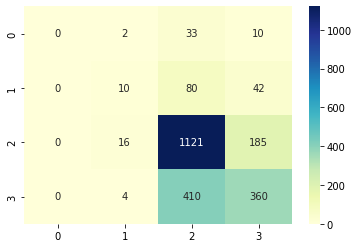

In [ ]:
# generamos la matriz de confusion para TF-iDF
MC2 = metrics.confusion_matrix(y_test, test_pred_idf)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

In [ ]:
print(classification_report(y_test,test_pred_idf))

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        45
                  Negative emotion       0.31      0.08      0.12       132
No emotion toward brand or product       0.68      0.85      0.76      1322
                  Positive emotion       0.60      0.47      0.53       774

                          accuracy                           0.66      2273
                         macro avg       0.40      0.35      0.35      2273
                      weighted avg       0.62      0.66      0.63      2273



## Metodo a elección

**Ridge**

In [ ]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier()
ridge.fit(datos_train, y_train)

# hacemos la prediccion de los datos de entrenamiento  
train_pred = ridge.predict(datos_train)

# hacemos la orediccion de los datos de prueba 
test_pred = ridge.predict(datos_test)

Procedemos a evaluar el modelo

In [ ]:
# Metricas para evaluar el modelo con los datos de prueba 
print('Accuracy score: ', format(accuracy_score(y_test, test_pred)))
print('Precision score: ', format(precision_score(y_test, test_pred,average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred,average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred,average='macro')))

RTF_ACC_TEST = accuracy_score(y_test, test_pred)
RTF_PS_TEST = precision_score(y_test, test_pred,average='macro')
RTF_RS_TEST = recall_score(y_test, test_pred,average='macro')
RTF_F1_TEST = f1_score(y_test, test_pred,average='macro')

Accuracy score:  0.6493620765508139
Precision score:  0.4018451272501552
Recall score:  0.35590341635401973
F1 score:  0.36335343256584307


In [ ]:
# Metricas para evaluar el modelo con los datos de prueba 
print('Accuracy score: ', format(accuracy_score(y_train, train_pred)))
print('Precision score: ', format(precision_score(y_train, train_pred, average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred, average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred, average='macro')))

RTF_ACC_TRAIN = accuracy_score(y_train, train_pred)
RTF_PS_TRAIN = precision_score(y_train, train_pred,average='macro')
RTF_RS_TRAIN = recall_score(y_train, train_pred,average='macro')
RTF_F1_TRAIN = f1_score(y_train, train_pred,average='macro')

Accuracy score:  0.7468837072884588
Precision score:  0.8195792446377521
Recall score:  0.4539031471806194
F1 score:  0.48801121105933315


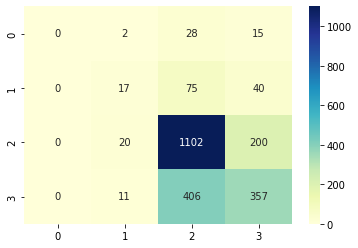

In [ ]:
# generamos la matriz de confusion
MC2 = metrics.confusion_matrix(y_test, test_pred)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

**Datos TF-iDF**

In [ ]:
Ridge_2 = RidgeClassifier()
Ridge_2.fit(datos_train_idf, y_train)


# hacemos la prediccion de los datos iDF de entrenamiento  
train_pred_idf = Ridge_2.predict(datos_train_idf)

# hacemos la orediccion de los datos iDF de prueba 
test_pred_idf = Ridge_2.predict(datos_test_idf)

Procedemos a evaluar el modelo

In [ ]:
# Metricas para evaluar el modelo con los datos de prueba de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_test, test_pred_idf)))
print('Precision score: ', format(precision_score(y_test, test_pred_idf, average='macro')))
print('Recall score: ', format(recall_score(y_test, test_pred_idf, average='macro')))
print('F1 score: ', format(f1_score(y_test, test_pred_idf, average='macro')))

RTFI_ACC_TEST = accuracy_score(y_test, test_pred_idf)
RTFI_PS_TEST = precision_score(y_test, test_pred_idf, average='macro')
RTFI_RS_TEST = recall_score(y_test, test_pred_idf, average='macro')
RTFI_F1_TEST = f1_score(y_test, test_pred_idf, average='macro')


Accuracy score:  0.6625604927408711
Precision score:  0.4149152814861653
Recall score:  0.355596388896885
F1 score:  0.36120206573749913


In [ ]:
# Metricas para evaluar el modelo con los datos de entrenamiento de TF-iDF
print('Accuracy score: ', format(accuracy_score(y_train, train_pred_idf)))
print('Precision score: ', format(precision_score(y_train, train_pred_idf, average='macro')))
print('Recall score: ', format(recall_score(y_train, train_pred_idf, average='macro')))
print('F1 score: ', format(f1_score(y_train, train_pred_idf, average='macro')))

RTFI_ACC_TRAIN = accuracy_score(y_train, train_pred_idf)
RTFI_PS_TRAIN = precision_score(y_train, train_pred_idf, average='macro')
RTFI_RS_TRAIN = recall_score(y_train, train_pred_idf, average='macro')
RTFI_F1_TRAIN = f1_score(y_train, train_pred_idf, average='macro')

Accuracy score:  0.7436574277753336
Precision score:  0.5708546390015838
Recall score:  0.4365286677086767
F1 score:  0.465166773165419


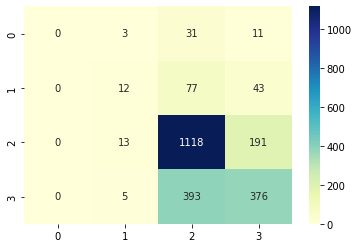

In [ ]:
# generamos la matriz de confusion para TF-iDF
MC2 = metrics.confusion_matrix(y_test, test_pred_idf)
p = sns.heatmap(pd.DataFrame(MC2), 
                annot=True, 
                cmap="YlGnBu",
                fmt = "g")

In [ ]:
print(classification_report(y_test,test_pred_idf))

                                    precision    recall  f1-score   support

                      I can't tell       0.00      0.00      0.00        45
                  Negative emotion       0.36      0.09      0.15       132
No emotion toward brand or product       0.69      0.85      0.76      1322
                  Positive emotion       0.61      0.49      0.54       774

                          accuracy                           0.66      2273
                         macro avg       0.41      0.36      0.36      2273
                      weighted avg       0.63      0.66      0.63      2273



## 6. Hacer una tabla de resumen de comparación de los modelos. Una con TF y otra con TF-iDF. La tabla debe contener en filas los métodos aplicados y en columnas las métricas así:

accuracy_train | accuracy_test | precision_train | precisio_test| .... . Igual con recall y f1_test

Elaboramos la tabla con la imformacion de los resultados para los datos de TF

In [ ]:
columns=['accuracy_train','accuracy_test',' precision_train',' precision_test', 'recall_train','recall_test', 'f1_train','f1_test']
index=['Naive Bayes Bernoulli','Naive Bayes Multinomial','Regresion Logistica', 'Ridge']
TF_data_frame = pd.DataFrame( index=index,columns=columns)
TF_data_frame.loc["Naive Bayes Bernoulli"]=[BTF_ACC_TRAIN, BTF_ACC_TEST, BTF_PS_TRAIN, BTF_PS_TEST,BTF_RS_TRAIN, BTF_RS_TEST, BTF_F1_TRAIN, BTF_F1_TEST]
TF_data_frame.loc["Naive Bayes Multinomial"]=[NBMTF_ACC_TRAIN, NBMTF_ACC_TEST, NBMTF_PS_TRAIN, NBMTF_PS_TEST,NBMTF_RS_TRAIN, NBMTF_RS_TEST, NBMTF_F1_TRAIN, NBMTF_F1_TEST]
TF_data_frame.loc["Regresion Logistica"]=[LTF_ACC_TRAIN, LTF_ACC_TEST, LTF_PS_TRAIN, LTF_PS_TEST, LTF_RS_TRAIN, LTF_RS_TEST, LTF_F1_TRAIN, LTF_F1_TEST]
TF_data_frame.loc["Ridge"]=[RTF_ACC_TRAIN, RTF_ACC_TEST, RTF_PS_TRAIN, RTF_PS_TEST, RTF_RS_TRAIN, RTF_RS_TEST, RTF_F1_TRAIN, RTF_F1_TEST]

TF_data_frame.head()


,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
Naive Bayes Bernoulli,0.676052,0.610207,0.571113,0.367805,0.499023,0.391298,0.489703,0.3767
Naive Bayes Multinomial,0.677372,0.610647,0.557282,0.369294,0.522218,0.394897,0.514603,0.378584
Regresion Logistica,0.761402,0.646282,0.805285,0.469944,0.521198,0.373353,0.568687,0.382936
Ridge,0.746884,0.649362,0.819579,0.401845,0.453903,0.355903,0.488011,0.363353


Elaboramos la tabla con la imformacion de los resultados para los datos de TF-iDF

In [ ]:
# tabla TF-iDF 
TFI_data_frame = pd.DataFrame( index=index,columns=columns)
TFI_data_frame.loc["Naive Bayes Bernoulli"]=[BTFI_ACC_TRAIN, BTFI_ACC_TEST, BTFI_PS_TRAIN, BTFI_PS_TEST,BTFI_RS_TRAIN, BTFI_RS_TEST, BTFI_F1_TRAIN, BTFI_F1_TEST]
TFI_data_frame.loc["Naive Bayes Multinomial"]=[NBMTFI_ACC_TRAIN, NBMTFI_ACC_TEST, NBMTFI_PS_TRAIN, NBMTFI_PS_TEST,NBMTFI_RS_TRAIN, NBMTFI_RS_TEST, NBMTFI_F1_TRAIN, NBMTFI_F1_TEST]
TFI_data_frame.loc["Regresion Logistica"]=[LTFI_ACC_TRAIN, LTFI_ACC_TEST, LTFI_PS_TRAIN, LTFI_PS_TEST, LTFI_RS_TRAIN, LTFI_RS_TEST, LTFI_F1_TRAIN, LTFI_F1_TEST]
TFI_data_frame.loc["Ridge"]=[RTFI_ACC_TRAIN, RTFI_ACC_TEST, RTFI_PS_TRAIN, RTFI_PS_TEST, RTFI_RS_TRAIN, RTFI_RS_TEST, RTFI_F1_TRAIN, RTFI_F1_TEST]

TFI_data_frame.head()

,accuracy_train,accuracy_test,precision_train,precision_test,recall_train,recall_test,f1_train,f1_test
Naive Bayes Bernoulli,0.676052,0.610207,0.571113,0.367805,0.499023,0.391298,0.489703,0.3767
Naive Bayes Multinomial,0.696583,0.641883,0.553791,0.443034,0.352911,0.314129,0.358905,0.305133
Regresion Logistica,0.733245,0.655961,0.572149,0.399347,0.419194,0.347208,0.446647,0.350754
Ridge,0.743657,0.66256,0.570855,0.414915,0.436529,0.355596,0.465167,0.361202


# 7. Hacer gráficos de barras: uno por cada métrica, en filas los algoritmos aplicados y en la altura la comparación del valor en train y test.

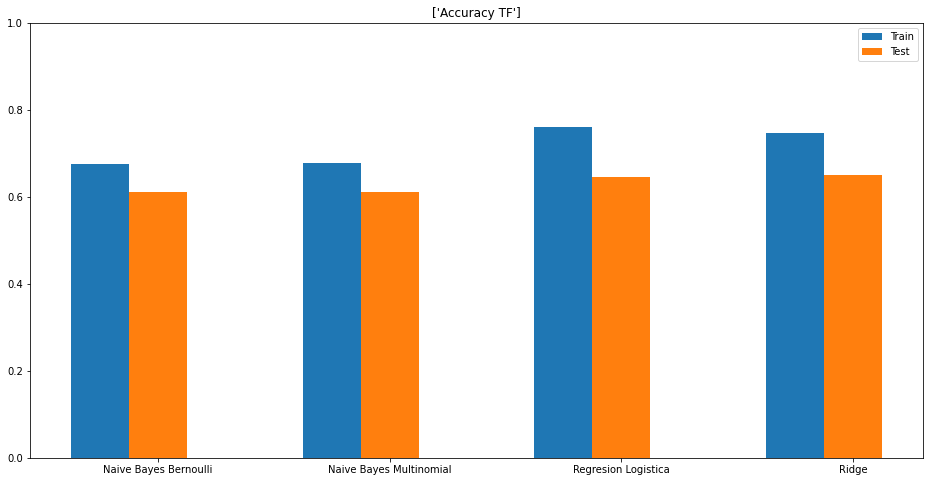

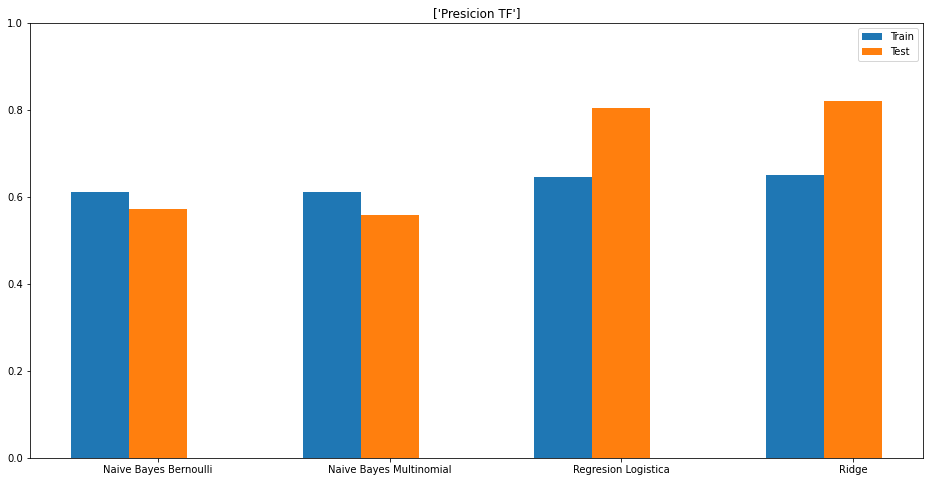

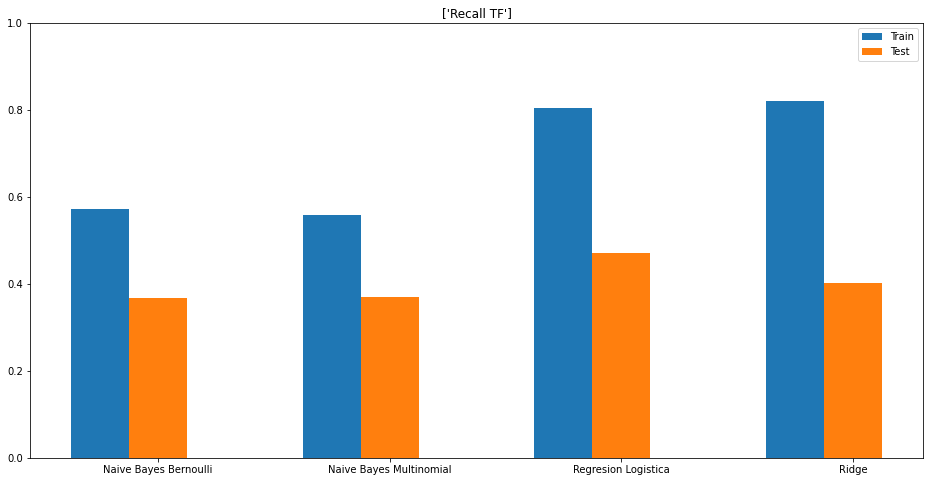

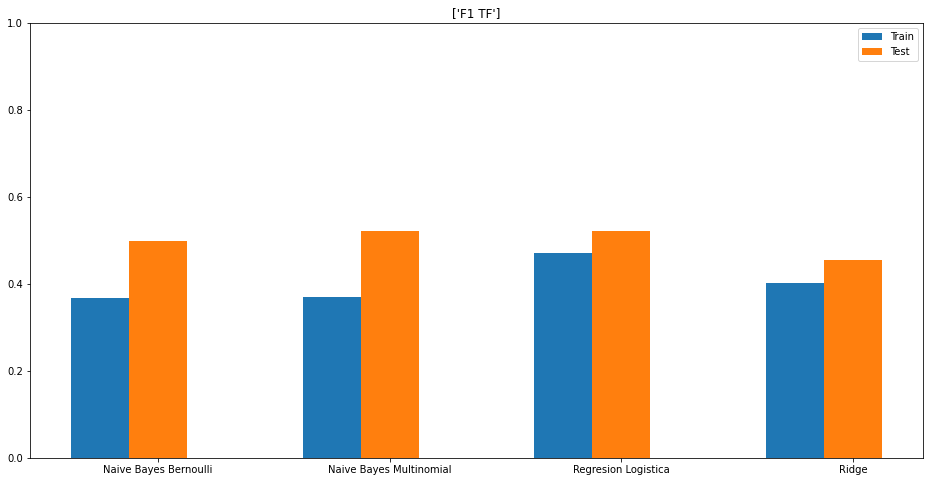

In [ ]:
# Grafica para los TF
n = len(TF_data_frame.index)
x = np.arange(n)
width = 0.25
title = ['Accuracy TF','Presicion TF','Recall TF','F1 TF']
for count in range(0,4):
  plt.figure(figsize=(16,8))
  plt.bar(x - width, TF_data_frame.iloc[:, 0+count]	, width=width, label='Train')
  plt.bar(x, TF_data_frame.iloc[:, 1+count], width=width, label='Test')
  plt.xticks(x, TF_data_frame.index)
  plt.legend(loc='best')
  plt.title(str([title[count]]))
  plt.ylim(0,1)
  plt.show()

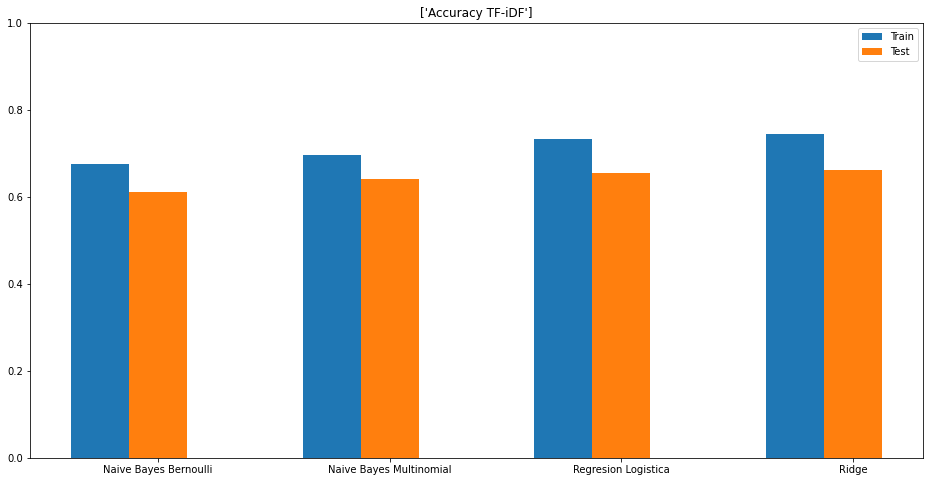

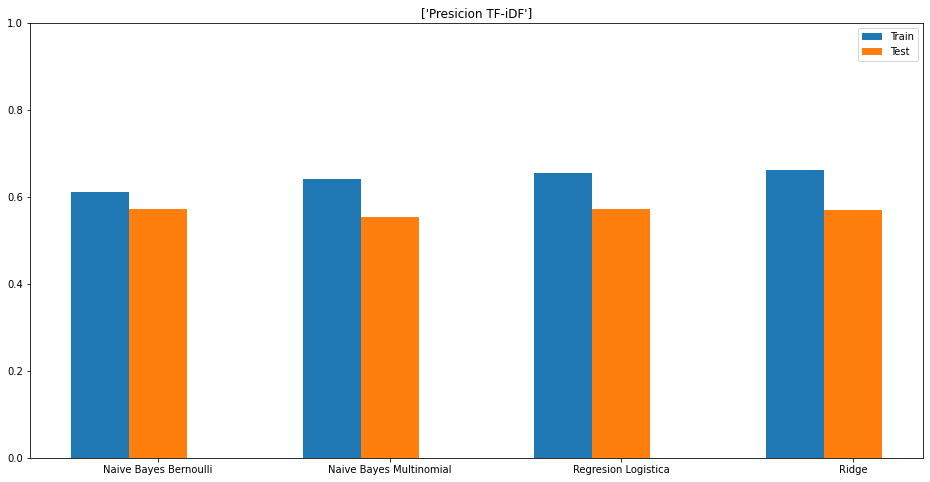

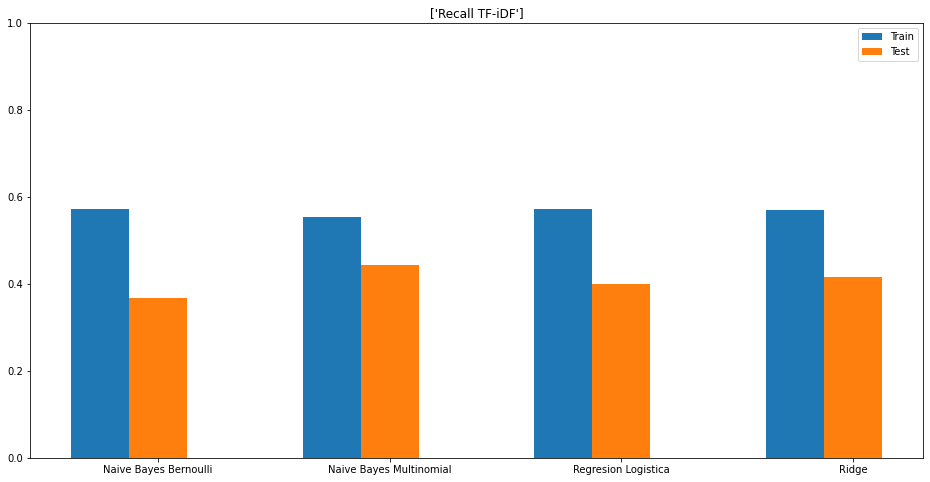

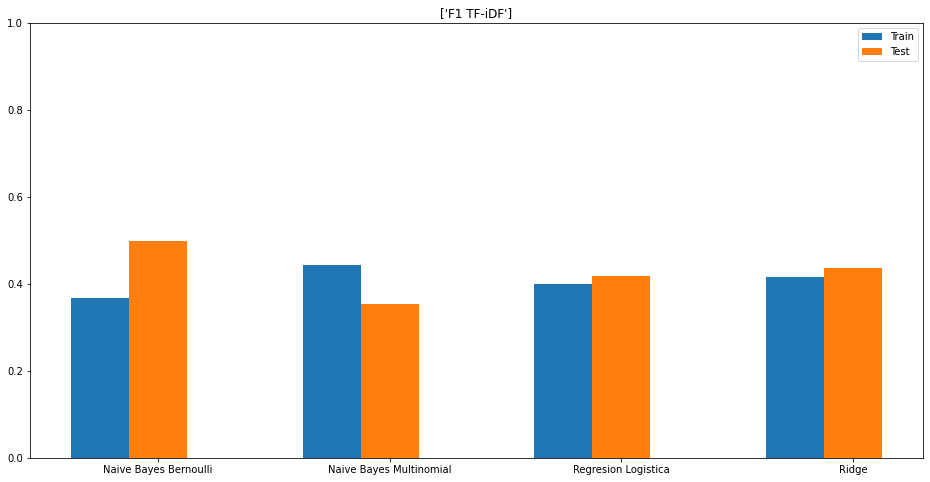

In [ ]:
# Grafica para los TF IDF
n = len(TFI_data_frame.index)
x = np.arange(n)
width = 0.25
title = ['Accuracy TF-iDF','Presicion TF-iDF','Recall TF-iDF','F1 TF-iDF']
for count in range(0,4):
  plt.figure(figsize=(16,8))
  plt.bar(x - width, TFI_data_frame.iloc[:, 0+count]	, width=width, label='Train')
  plt.bar(x, TFI_data_frame.iloc[:, 1+count], width=width, label='Test')
  plt.xticks(x, TFI_data_frame.index)
  plt.legend(loc='best')
  plt.title(str([title[count]]))
  plt.ylim(0,1)
  plt.show()

## Conclusiones

*   En el presente informe se realizo el pre procesamiento de tweets con su respectiva limpieza y analisis de información, posteriormente se determino seleccionar las 1000 palabras mas repetidas y que estuviera en 3 documentos. Sobre esta información se realizan 4 metodos de clasificación con la finalidad de observar el comportamiento de la información y cual es el metodo que mejor la clasifica, los metodos utilizados fueron: Naive Bayes Bernoulli, Naive Bayes Multinomial, Regresión logistica y Clasficador de Ridge.

In [ ]:
import plotly.express as px
fig = px.histogram(TF_data_frame, x=['Naive Bayes Bernoulli','Naive Bayes Multinomial','Regresion Logistica', 'Ridge'], y=['accuracy_train','accuracy_test',' precision_train',' precision_test', 'recall_train','recall_test', 'f1_train','f1_test'], barmode='group')
fig.show()






*   La grafica anterior nos muestra toda la información junta de las tablas de TF, donde estan juntos los valores de train y test en ese orden y en orden de 'accuracy_train','accuracy_test',' precision_train',' precision_test', 'recall_train','recall_test', 'f1_train','f1_test' bajo los 4 metodos utilizados


*   Para analizar la información  proporcionada en los metodos de clasificación nos centramos en los datos test, por esta razón el accuracy  el mejor es el clasificador de Ridge (0.649), en precision el mejor fue regresión logistica (0.469), recall  es Naive Bayes Multinomial(0.394), y f1 es Regresión logistica(0.382). Note que estos valores estan sujetos a cada ejecucion del codigo.



In [ ]:
fig2 = px.histogram(TFI_data_frame, x=['Naive Bayes Bernoulli','Naive Bayes Multinomial','Regresion Logistica', 'Ridge'], y=['accuracy_train','accuracy_test',' precision_train',' precision_test', 'recall_train','recall_test', 'f1_train','f1_test'], barmode='group')
fig2.show()


  
*   La grafica anterior nos muestra toda la información junta de las tablas de TF-IDF, donde estan juntos los valores de train y test en ese orden y en orden de 'accuracy_train','accuracy_test',' precision_train',' precision_test', 'recall_train','recall_test', 'f1_train','f1_test' bajo los 4 metodos utilizados


*   Para analizar la información  proporcionada en los metodos de clasificación nos centramos en los datos test, por esta razón en el accuracy el mayor porcentaje es del clasificador de Ridge (0.662), en precision Naives Bayes Multinomial(0.443), recall el Naive Bayes Bernoulli (0.391) y f1 Naive Bayes Bernoulli(0.376), por lo tanto, el mejor clasificador para los datos TF-IDF estan en el clasficador Naive Bayes Bernoulli.

* Los modelos de Bernoulli, Multinomial y Ridge son los que mejor manejan la clase de TF pues tienen una Precisión y un Recal nivelados mientras que la Regresion Logistica tiene mas dificutados haciendo la clasificacion para este conjunto de datos.

* Note que el modelo Bernoulli es el que mejor maneja la clase de TF-iDF pues es el que tiene mejor Precision y mejor Recall. Por otro lado el Mutinomial no detecta la clase muy bien, pero cuando lo hace es altamente confiable pues tiene una alta Precision pero un bajo Recall para las TF-iDF.

* Note que Bernoulli entre todos los modelos para TF-iDF fue el que peor Accuracy tuvo sobre sus datos de entrenamiento, pero a su vez fue el que mejor Recall tuvo sobre los datos de entrenamiento, esto quiere decir que fue el que mejor ajusto sus pesos durante la etapa de entrenamiento, ya que, una vez se le pasaron nuevamente los datos de entrenamiento, hizo una buena clasificación.

*  En general se debe tener en cuenta que el modelo se evalúa con los datos de prueba, es por eso que se hace la segmentación en datos de entrenamiento y datos de prueba, dicho esto, el modelo que mejor desempeño tuvo fue el de Ridge, el caso que más llama la atención es en el modelo de Naive Bayes Bernoulli porque tiene el Accuracy más bajo de todos los modelos con los datos de entrenamiento, esto se puede dar ya que las separación entre los datos no es tan obvia, por lo que al momento de hacer la clasificación puede "perderse" más fácil el algoritmo, como solucion a esto en el caso cuantitativo se podría hacer una transformación de los datos, como por ejemplo aplicar una rotación en el plano cartesiano que maximice la variabilidad de los datos. En este caso, en el caso cualitativo, se podría buscar una forma de cuantificar los datos y aplicar dicha rotación en el plano. También esta la transformación logarítmica, es útil cuando los datos tienen una distribución asimétrica positiva (es decir, una cola hacia la derecha) y la varianza aumenta con el nivel de la variable. Al aplicar la transformación logarítmica a los datos, se reduce la magnitud de los valores extremos y se hace que la distribución sea más simétrica. Esto a menudo resulta en una mayor varianza, ya que los valores extremos pueden estar limitando la varianza de los datos originales, nuevamente, luego de cuantificar los datos.

* De forma general se puede decir que los modelos de clasificación empleados no son los mejores para nuestro conjunto de datos, pues se esperaría que por lo menos una vez se le vuelva a pasar los datos de entrenamiento tuviera una precisión por arriba de 0.9, pero ninguno llega a estos números. Para mejorar los resultados se podría hacer una mejor segmentación de los datos y aumentar el tamaño de la muestra de los datos de entrenamiento.





